In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# 1. Analizando columnas

In [230]:
def get_null_cols_vals(df:pd.DataFrame) -> dict:
    cols = df.columns
    nulls = {}
    for col in cols:
        nulls[col] = round((df[col].isnull().sum() / len(df[col]))*100, 2)
    return nulls    


In [251]:
df = pd.read_excel("./Caso 01 - Cobranza Sector Financiero.xlsx")

In [232]:
get_null_cols_vals(df)

{'Consecutivo Documento Deudor': 0.0,
 'Nit': 0.0,
 'Nombres': 100.0,
 'Numero Documento': 100.0,
 'Tipo De Producto': 0.0,
 'PRODUCTO': 0.0,
 'Valor Obligacion': 0.0,
 'Valor Vencido': 0.0,
 'Regional': 0.0,
 'REGION': 0.0,
 'Abogado': 0.0,
 'Dias Mora': 0.0,
 'FRANJA': 0.0,
 'Fecha Traslado Para Cobro': 0.01,
 'Fecha Ultima Facturacion': 9.93,
 'Segmento': 0.01,
 'Oficina Radicacion': 0.0,
 'Red': 0.0,
 'Cuadrante': 1.68,
 'Descripcion Causal': 0.32,
 'Calificacion Real': 0.0,
 'Fecha De Perfeccionamiento': 0.0,
 'Endeudamiento': 0.0,
 'Rango endeudamiento': 0.0,
 'Sector Economico': 56.81,
 'Profesion': 0.66,
 'Ocupacion': 0.21}

In [252]:
df = df.drop(columns = ["Nombres", "Numero Documento", "Consecutivo Documento Deudor", "Nit", "Tipo De Producto", "Valor Vencido",
             "Valor Obligacion", "Abogado", "Fecha Ultima Facturacion", "Oficina Radicacion", "Fecha Traslado Para Cobro", 
             "Red", "Sector Economico", "Profesion", "Regional", "REGION"]) #elimino columnas no relevantes para el modelo

In [234]:
get_null_cols_vals(df)

{'PRODUCTO': 0.0,
 'Dias Mora': 0.0,
 'FRANJA': 0.0,
 'Segmento': 0.01,
 'Cuadrante': 1.68,
 'Descripcion Causal': 0.32,
 'Calificacion Real': 0.0,
 'Fecha De Perfeccionamiento': 0.0,
 'Rango endeudamiento': 0.0,
 'Ocupacion': 0.21}

In [235]:
df = df.dropna() #dropeo nulos ya que en el peor de los casos representan solo un 2% de mis datos

# 2. Preprocesamiento

In [110]:
def date_to_str(row):
    if isinstance(row, datetime.datetime):
        return "1-15"
    return row

def trim_spaces(row:str) -> str:
    return row.replace(" ", "")

In [111]:
df["Rango Endeudamiento"] = df["Rango endeudamiento"].apply(date_to_str) #convertir fecha a rango str
df = df.drop(columns = ["Rango endeudamiento"])

In [132]:
cat_cols = df.select_dtypes("object") #obtener columnas categoricas
encoders = {}
for col in cat_cols: 
    encoder = LabelEncoder()
    df[f"{col} num"] = encoder.fit_transform(df[col]) #convertir columna cat a num
    encoders[col] = encoder #almaceno el scaler de la columna

In [150]:
df_num = df.select_dtypes(np.number) #selecciono columnas num

In [151]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_num.to_numpy())
df_num_scaled = pd.DataFrame(scaled_data, columns = df_num.columns)

# 3. Modelos de ML

In [114]:
evualate_cols = ["Calificacion Real", "Regional", "Dias Mora"] #evaluar desempeño del modelo con y sin estas columnas

## 3.1 KMeans

### 3.1.1 Grafica de codo

In [168]:
def elbows_data(interval:list) -> dict or int:
    if len(interval) > 2:
        raise ValueError(f"Interval must contain only 2 values not {len(interval)}")
    try:
        data = {}
        clusters = []
        inertias = []
        for i in range(interval[0], interval[1]):
            k_model = KMeans(n_clusters= i)
            k_model.fit(df_num_scaled)
            clusters.append(i)
            inertias.append(k_model.inertia_)
        data["clusters"] = clusters
        data["inertias"] = inertias
        return data
    except ValueError as error:
        print(error)
        return 0

Intervalo 1 a 30

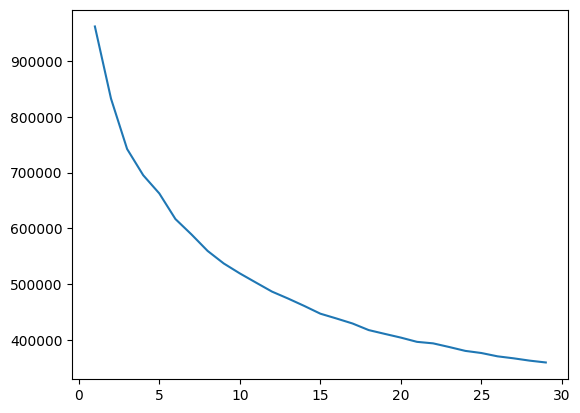

In [169]:
#grafica del codo con intervalo 1 a 30
data = elbows_data([1, 30])
plt.plot(data["clusters"], data["inertias"])
plt.show()

Intervalo 1 a 10

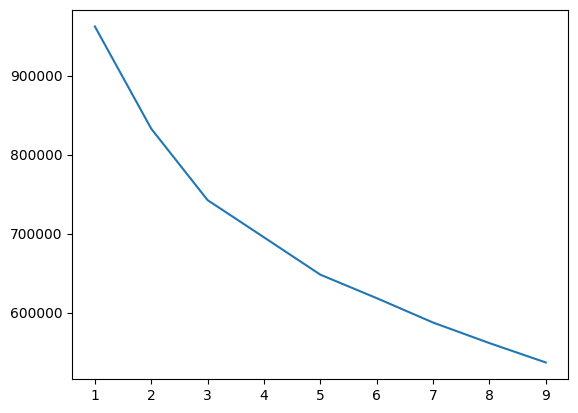

In [170]:
data = elbows_data([1,10])
plt.plot(data["clusters"], data["inertias"])
plt.show()

Intervalo 2 a 5

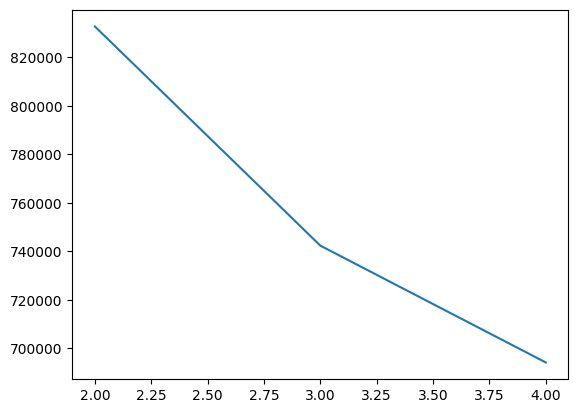

In [171]:
data = elbows_data([2,5])
plt.plot(data["clusters"], data["inertias"])
plt.show()

El codo esta en 3 intervalos

In [175]:
kmeans = KMeans(n_clusters= 3)
kmeans.fit(df_num_scaled)
df_num_scaled["Group"] = kmeans.predict(df_num_scaled)

### 3.1.2 PCA

Grafica de la varianza acumulada

In [190]:
pca = PCA()
pca.fit(df_num_scaled)

PCA()

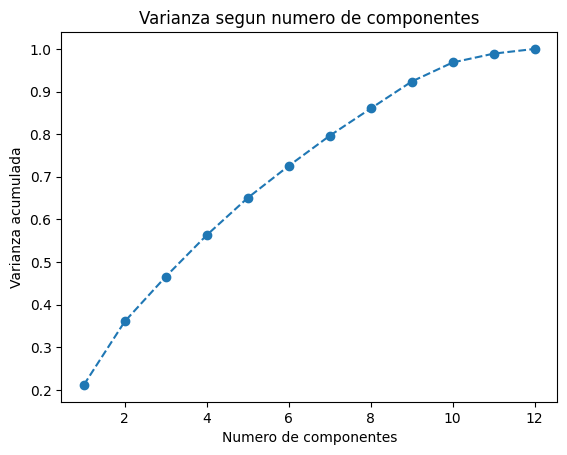

In [191]:
#graficando la varianza acumulada
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker = "o", linestyle = "--")
plt.title("Varianza segun numero de componentes")
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza acumulada")
plt.show()

In [ ]:
#una de las reglas es quedarse con el 80% de la varianza


### 3.1.3 Graficando KMeans

In [205]:
pca = PCA(n_components= 2)
pca_data = pca.fit_transform(df_num_scaled)
df_pca = pd.DataFrame(pca_data, columns = ["Col1", "Col2"])

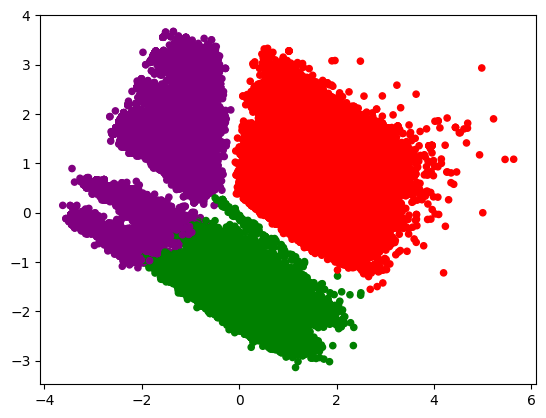

In [219]:
colors = ["red", "green", "purple"]
groups = df_num_scaled["Group"]
points_colors = []
for group in groups: #asignar un color a cada uno de los grupos    
    points_colors.append(colors[group])
plt.scatter(df_pca["Col1"], df_pca["Col2"], c=points_colors, s = 20) 
plt.scatter()

In [221]:
df_num_scaled.corr(method = "pearson")

,Regional,Dias Mora,Calificacion Real,PRODUCTO num,REGION num,FRANJA num,Segmento num,Cuadrante num,Descripcion Causal num,Ocupacion num,Rango Endeudamiento num,Group
Regional,1.000000,0.059138,0.042854,-0.037308,0.759456,-0.064903,-0.065697,0.013171,-0.019056,-0.007337,0.020463,-0.430544
Dias Mora,0.059138,1.000000,0.175446,0.001158,0.071044,-0.105370,-0.004739,0.078543,-0.083010,0.005186,0.030825,-0.139799
Calificacion Real,0.042854,0.175446,1.000000,-0.095056,0.045388,-0.130462,-0.009985,0.152736,-0.155594,-0.117475,-0.039758,-0.233088
PRODUCTO num,-0.037308,0.001158,-0.095056,1.000000,-0.045849,0.115570,-0.009846,-0.118815,0.134783,0.058882,0.044648,0.156562
REGION num,0.759456,0.071044,0.045388,-0.045849,1.000000,-0.071416,-0.067940,0.013412,-0.014857,-0.009362,0.004235,-0.447285
FRANJA num,-0.064903,-0.105370,-0.130462,0.115570,-0.071416,1.000000,-0.006245,-0.088071,0.142232,0.002130,0.058177,0.174135
Segmento num,-0.065697,-0.004739,-0.009985,-0.009846,-0.067940,-0.006245,1.000000,-0.073122,0.050472,0.049378,0.225997,0.115048
Cuadrante num,0.013171,0.078543,0.152736,-0.118815,0.013412,-0.088071,-0.073122,1.000000,-0.476749,-0.290216,-0.068991,-0.635567
Descripcion Causal num,-0.019056,-0.083010,-0.155594,0.134783,-0.014857,0.142232,0.050472,-0.476749,1.000000,0.261517,0.059153,0.582005
Ocupacion num,-0.007337,0.005186,-0.117475,0.058882,-0.009362,0.002130,0.049378,-0.290216,0.261517,1.000000,0.054108,0.344487


# 4. Further Analisis 

In [256]:
df = df[df["Ocupacion"] != "NO APLICA A ESTE PRODUCTO"] #quito todas las filas que no tengan ocupacion

## 4.1 Analizando rangos de endeudamiento

In [307]:
def get_employed(row:str) -> int:
    if row == "SIN OFICIO":
        return 0
    else:
        return 1



def get_debt_groups(row:float) -> str:
    if row > 0 and row <= 100000000:
        return "[0 - 100M]"
    elif row > 100000000 and row <= 500000000:
        return "[100M - 500M]"
    else:
        return "[500M - 2000M]"



def get_new_debt_groups(row:float) -> str:
    if row > 0 and row < 30000000: 
        return "[0 - 30M]"
    elif row > 30000000 and row < 60000000:
        return "[30M - 60M]"
    else:
        return "[60M - inf]"

In [288]:
df["Employeed"] = df["Ocupacion"].apply(get_employed) #obtengo personas que tienen empleo y que noM

C:\Users\puert\AppData\Local\Temp\ipykernel_10008\866127153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Employeed"] = df["Ocupacion"].apply(get_employed) #obtengo personas que tienen empleo y que noM


In [289]:
df["Debt Group"] = df["Endeudamiento"].apply(get_debt_groups)

C:\Users\puert\AppData\Local\Temp\ipykernel_10008\2147055644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Debt Group"] = df["Endeudamiento"].apply(get_debt_groups)


In [290]:
df["Debt Group"].value_counts() #hallar personas de los diferentes grupos de endeudamiento

[0 - 100M]        87423
[100M - 500M]      1134
[500M - 2000M]       23
Name: Debt Group, dtype: int64

In [291]:
#endeudamiento por grupo
debts = {}
for group in set(df["Debt Group"]):
    debt = df["Endeudamiento"][df["Debt Group"] == group].sum()
    debts[group] = debt
debts 

{'[500M - 2000M]': 19381000917.870003,
 '[100M - 500M]': 181623708430.57,
 '[0 - 100M]': 1065261956489.9298}

La mayor deuda se encuentra en el grupo que mas debe

In [292]:
debt_100_500 = debts["[100M - 500M]"] + debts["[500M - 2000M]"]
debt_100_500_percentage = (debt_100_500 / df["Endeudamiento"].sum()) * 100

In [294]:
print(f"Las personas que deben entre 100M y 2000M correponden al {round(debt_100_500_percentage, 2)}% del endeudamiento total de la compañia")

Las personas que deben entre 100M y 2000M correponden al 15.87% del endeudamiento total de la compañia


In [308]:
new_debt = df[df["Debt Group"] == "[0 - 100M]"]
new_debt["Debt Group"] = new_debt["Endeudamiento"].apply(get_new_debt_groups)

C:\Users\puert\AppData\Local\Temp\ipykernel_10008\3723120675.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_debt["Debt Group"] = new_debt["Endeudamiento"].apply(get_new_debt_groups)


In [309]:
new_debt["Debt Group"].value_counts()

[0 - 30M]      76386
[30M - 60M]     8189
[60M - inf]     2848
Name: Debt Group, dtype: int64

In [311]:
debts = {}
for group in set(new_debt["Debt Group"]):
    debt = new_debt["Endeudamiento"][new_debt["Debt Group"] == group].sum()
    debts[group] = debt
debts 

{'[30M - 60M]': 340069421288.44995,
 '[60M - inf]': 217247922792.12,
 '[0 - 30M]': 507944612409.3599}

In [314]:
debt_30_inf = debts["[60M - inf]"] + debts["[30M - 60M]"]
debt_30_inf_percentage = (debt_100_500 / df["Endeudamiento"].sum()) * 100

In [320]:
print(f"El endeudamiento total del grupo de 30M a 100M es de: {debt_30_inf} lo cual corresponde a {debt_30_inf_percentage}% del endeudamiento")

El endeudamiento total del grupo de 30M a 100M es de: 557317344080.57 lo cual corresponde a 44.01263644665093% del endeudamiento


In [331]:
optimal_group = new_debt[new_debt["Debt Group"] != "[0 - 30M]"]

## 4.2 Analizando cuadrante

In [332]:
len(optimal_group[optimal_group["Cuadrante"] == "TIENE VOLUNTAD Y TIENE CAPACIDAD"]) #numero de personas que tiene capacidad y voluntad para pagar

3503

In [333]:
reasons = optimal_group["Descripcion Causal"][optimal_group["Cuadrante"] == "TIENE VOLUNTAD Y TIENE CAPACIDAD"].value_counts()

In [347]:
optimal_group["Endeudamiento"][(optimal_group["Descripcion Causal"] == "DESCUIDO") & (optimal_group["Cuadrante"] == "TIENE VOLUNTAD Y TIENE CAPACIDAD")].sum() 

62130708700.36

In [341]:
#las personas que no pagan por descuido son: %
(reasons["DESCUIDO"] / len(optimal_group[optimal_group["Cuadrante"] == "TIENE VOLUNTAD Y TIENE CAPACIDAD"])) * 100

34.37053953753925